In [2]:
import os
from tqdm import tqdm
import json 
from occwl.compound import Compound 
from occwl.graph import face_adjacency
from occwl.entity_mapper import EntityMapper
from occwl.jupyter_viewer import JupyterViewer as Viewer
from multiprocessing.pool import Pool
import pandas as pd
import matplotlib.pyplot as plt
import signal
def initializer():
    """Ignore CTRL+C in the worker process."""
    signal.signal(signal.SIGINT, signal.SIG_IGN)

In [3]:
def get_name_map():
    name_mapping = {}

    base_dir = "../../mfcad/labels/"
    for file in tqdm(os.listdir(base_dir)):
        if file[0] != '.':
            with open(base_dir+file, 'r') as f:
                data = json.load(f)
            for face in data['body']['faces']:
                name_mapping[face['segment']['index']]=face['segment']['name']
    return name_mapping

In [4]:
import pandas as pd
def get_name_map():
    name_mapping = {}
    return pd.read_csv("../../data/MFCAD++_dataset/feature_labels.txt", skiprows=6, header=None, sep=" - ").set_index(0)[1].to_dict()


In [5]:
# with open("../../labels_100ep_model_fix2.json", 'r') as f:

with open("../../test_labels/labels_10ep_model_20samples_new_data.json", 'r') as f:
    labels = json.load(f)
with open("../../data/janush_dataset//non_duplicated_filenames.json", 'r') as f:
    allowed = set(json.load(f))
labels = [x for x in labels if x['part'] in allowed]

name_map = get_name_map()
len(labels)

/tmp/ipykernel_9145/2325836227.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv("../../data/MFCAD++_dataset/feature_labels.txt", skiprows=6, header=None, sep=" - ").set_index(0)[1].to_dict()


469

In [6]:
groups = {"Chamfer": ["Chamfer", "Round"], 
          "Passage": ['Triangular passage', 'Rectangular passage', '6-sided passage'],
          "Through slot" :['Triangular through slot', 'Rectangular through slot', 'Circular through slot'], 
          "Through step": ['Rectangular through step', '2-sided through step', 'Slanted through step'],
          "Closed pocket": ['Triangular pocket', 'Rectangular pocket', '6-sided pocket', 'Circular end pocket', 'Blind hole', "O-ring"],
          "Blind Slot": ['Rectangular blind slot', 'Vertical circular end blind slot', 'Horizontal circular end blind slot'],
          "Blind step": ['Triangular blind step', 'Circular blind step']}

new_map = {}
id_map = {}
for k, v in name_map.items():
    passed = False
    for k1, v1 in groups.items():
        if v in v1:
           new_map[k] = k1
           passed = True
    if not passed:
        new_map[k] = v
id_map = {}
for i,k in enumerate(set(new_map.values())):
    id_map[k] = i
new_map = {k: id_map[v] for k,v in new_map.items()} 

In [7]:
def get_mechanical_features(filename):
    features = []
    with open(f"../../data/janush_dataset/raw/{filename}.FRT", 'r') as f:
        for line in f:
            if line:
                features.append([x for x in line.split(",") if x and x != "\n"])
    return features

In [8]:
def estimate_result(l):
    shape, mapping = Compound.load_step_with_attributes(f"../../data/janush_dataset//raw/{l['part']}.stp")
    mechanical_features = get_mechanical_features(l['part'])
    flat_faces = []
    [flat_faces.extend(x) for x in mechanical_features]

    truth = [1000] * shape.num_faces()

    index_map = {}
    for i, face in enumerate(shape.faces()):
        try:
            index_map[mapping[face]['name']] = i
            if mapping[face]['name'] in flat_faces:
                truth[i] = 1
        except KeyError as e:
            pass
    
    mechanical_features = [[index_map[y] for y in x] for x in mechanical_features]
    
    occs = []
    for i, cls in enumerate(l['labels']):
        if truth[i] == 1:
            occs.append(new_map[cls])
    return {"part": l['part'], "shape": shape, "truth": truth,
            "mechanical_features": mechanical_features, "occurencies": occs, 
            "predict": [new_map[x] for x in l['labels']]}

In [9]:
pool = Pool(processes=50, initializer=initializer)
try:
    results = list(tqdm(pool.imap(estimate_result, labels), total=len(labels)))
except KeyboardInterrupt:
    pool.terminate()
    pool.join()

100%|██████████| 469/469 [00:13<00:00, 33.89it/s]


In [10]:
occs = []
for x in results:
    occs.extend(x['occurencies'])
pd.Series(occs).value_counts()

3    9999
4     394
7     278
0     217
9     153
6     145
5      64
2      17
1      14
8       4
dtype: int64

In [11]:
import numpy as np

avg_max_dominance = {}
for k,v in occs_features.items():
    values = []
    for feats in v:
        values.append(max(pd.Series(feats).value_counts()) / len(feats))
    avg_max_dominance[k] = np.mean(values)

NameError: name 'occs_features' is not defined

In [ ]:
from matplotlib import pyplot as plt

plt.hist(list(avg_max_dominance.values()))

In [12]:
import numpy as np
def weighted_normalized_jaccard(set1, set2):
    """
    Calculates the weighted normalized Jaccard index between two sets.
    
    Arguments:
    set1 -- a set of elements (ground truth)
    set2 -- a set of elements (predicted)
    
    Returns:
    The weighted normalized Jaccard index between the two sets.
    """
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard = len(intersection) / len(union) if len(union) > 0 else 0
    weight = len(set1) / len(set2) if len(set2) > len(set1) else len(set2) / len(set1)
    return jaccard * weight

def get_mf(graph, truth, labels):
    mfs = [set() for _ in range(len(truth))]
    def check_node(graph, start_truth, i, labels):
        target_label = labels[start_truth]
        mfs[i].update([start_truth])
        for k in graph.neighbors(start_truth):
            if labels[k] == target_label:
                if k not in mfs[i]:
                    mfs[i].update([start_truth])
                    check_node(graph, k, i, labels)
    
    for i, start_truth in enumerate(truth):
        check_node(graph, start_truth, i, labels)
    max_measure = -1
    max_index = -1
    for i, mf in enumerate(mfs):
        measure = weighted_normalized_jaccard(set(truth), mf)
        if measure > max_measure:
            max_measure = measure
            max_index = i
    return mfs[max_index], max_measure

In [13]:
def get_predicted_mf(r):
    graph = face_adjacency(r['shape'])
    mfs = {}
    for truth in r['mechanical_features']:
        mfs[tuple(truth)] = get_mf(graph, truth, r['predict'])
    return {r['part']: [np.mean([x[1] for x in mfs.values()]), mfs]}

In [14]:
pool = Pool(processes=50, initializer=initializer)
try:
    predicted_mfs = list(tqdm(pool.imap(get_predicted_mf, results), total=len(results)))
except KeyboardInterrupt:
    pool.terminate()
    pool.join()


100%|██████████| 469/469 [01:33<00:00,  5.03it/s]


In [15]:
prediced = {}
for x in predicted_mfs:
    prediced.update(x)

0.4778964135805167

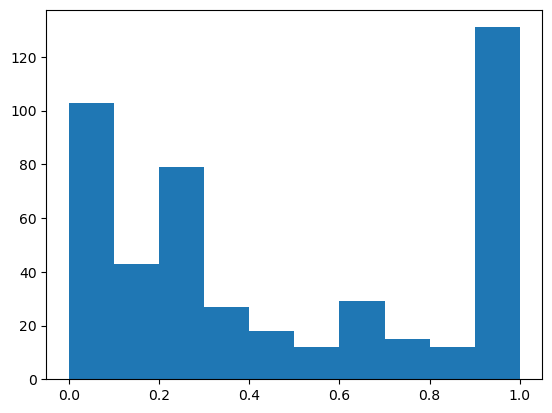

In [16]:
plt.hist([x[0] for x in prediced.values()])
np.mean([x[0] for x in prediced.values()])

In [55]:
def plot_truth(res):
    v = Viewer()
    v.display_face_colormap(res['shape'], res['truth'])
    v.show()

def plot_labels(res):
    print(f"prediction for {res['part']}")
    all_feats = []                       
    for i, feature in enumerate(res['mechanical_features']):
        print(f"Feature {i}:")
        counter = []
        for face in feature:
            counter.append(res['predict'][face])
        print(pd.Series(counter).value_counts())
        all_feats.extend(counter)
        print("total")
    print(pd.Series(all_feats).value_counts())
    v = Viewer()
    
    v.display_face_colormap(res['shape'], res['predict'])
    v.show()

In [56]:
ind = 14

print(prediced[perfect_matches[ind]['part']][0])
plot_truth(perfect_matches[ind]), plot_labels(perfect_matches[ind])

NameError: name 'perfect_matches' is not defined

In [31]:
print(1)

In [37]:
r = top_truth['00350942_583bc49850155f10b9b140fd_step_000_step']
plot_truth(r), plot_labels(r)

NameError: name 'top_truth' is not defined

In [ ]:
r = top_truth['00350942_583bc49850155f10b9b140fd_step_000_step']
plot_truth(r), plot_labels(r)

In [ ]:
r = results[100]
len(r['predict']), len(r['truth']), len(list(r['shape'].faces()))

In [ ]:
r['predict']

In [39]:
import argparse
import pathlib
import json
import dgl
import numpy as np
import torch
from occwl.graph import face_adjacency
from occwl.compound import Compound
from occwl.uvgrid import ugrid, uvgrid
from tqdm import tqdm
from multiprocessing.pool import Pool
from itertools import repeat
import signal
def initializer():
    """Ignore CTRL+C in the worker process."""
    signal.signal(signal.SIGINT, signal.SIG_IGN)

def build_graph(solid, curv_num_u_samples, surf_num_u_samples, surf_num_v_samples):
    # Build face adjacency graph with B-rep entities as node and edge features
    graph = face_adjacency(solid)

    # Compute the UV-grids for faces
    graph_face_feat = []
    for face_idx in graph.nodes:
        # Get the B-rep face
        face = graph.nodes[face_idx]["face"]
        # Compute UV-grids
        points = uvgrid(
            face, method="point", num_u=surf_num_u_samples, num_v=surf_num_v_samples
        )
        # print(points)
        normals = uvgrid(
            face, method="normal", num_u=surf_num_u_samples, num_v=surf_num_v_samples
        )
        visibility_status = uvgrid(
            face, method="visibility_status", num_u=surf_num_u_samples, num_v=surf_num_v_samples
        )
        mask = np.logical_or(visibility_status == 0, visibility_status == 2)  # 0: Inside, 1: Outside, 2: On boundary
        # Concatenate channel-wise to form face feature tensor
        face_feat = np.concatenate((points, normals, mask), axis=-1)
        graph_face_feat.append(face_feat)
    graph_face_feat = np.asarray(graph_face_feat)

    # Compute the U-grids for edges
    graph_edge_feat = []
    for edge_idx in graph.edges:
        # Get the B-rep edge
        edge = graph.edges[edge_idx]["edge"]
        # Ignore dgenerate edges, e.g. at apex of cone
        if not edge.has_curve():
            continue
        # Compute U-grids
        points = ugrid(edge, method="point", num_u=curv_num_u_samples)
        tangents = ugrid(edge, method="tangent", num_u=curv_num_u_samples)
        # Concatenate channel-wise to form edge feature tensor
        edge_feat = np.concatenate((points, tangents), axis=-1)
        graph_edge_feat.append(edge_feat)
    graph_edge_feat = np.asarray(graph_edge_feat)

    # Convert face-adj graph to DGL format
    edges = list(graph.edges)
    src = [e[0] for e in edges]
    dst = [e[1] for e in edges]
    dgl_graph = dgl.graph((src, dst), num_nodes=len(graph.nodes))
    dgl_graph.ndata["x"] = torch.from_numpy(graph_face_feat)
    dgl_graph.edata["x"] = torch.from_numpy(graph_edge_feat)
    return dgl_graph


def process_one_file(arguments):
    try:
        fn, args = arguments
        fn_stem = fn.stem
        output_path = pathlib.Path(args.output)
        solid, mapping = Compound.load_step_with_attributes(fn)
        #solid = solid[0]
        if args.convert_labels:
            labels = [int(mapping[face]['name']) for face in solid.faces() if face in mapping]
            with open(str(output_path)+"_labels/"+fn_stem+".json", 'w') as f:
                json.dump(labels, f)
        graph = build_graph(
            solid, args.curv_u_samples, args.surf_u_samples, args.surf_v_samples
        )
        dgl.data.utils.save_graphs(str(output_path.joinpath(fn_stem + ".bin")), [graph]) #_color
    except Exception as e:
        print(e)


def initializer():
    """Ignore CTRL+C in the worker process."""
    signal.signal(signal.SIGINT, signal.SIG_IGN)


def process(args):
    input_path = pathlib.Path(args.input)
    output_path = pathlib.Path(args.output)
    if not output_path.exists():
        output_path.mkdir(parents=True, exist_ok=True)
    step_files = list(input_path.glob("*.st*p"))
    # for fn in tqdm(step_files):
    #     process_one_file(fn, args)
    pool = Pool(processes=50, initializer=initializer)
    try:
        results = list(tqdm(pool.imap(process_one_file, zip(step_files, repeat(args))), total=len(step_files)))
    except KeyboardInterrupt:
        pool.terminate()
        pool.join()
    print(f"Processed {len(results)} files.")

In [ ]:
# path_data_raw = "../../data/machining_features_sprint_1/raw"
# path_data = "../../data/machining_features_sprint_1/graphs_20/"

# path_data_raw = "../../MFCAD/dataset/step"
# path_data = "/home/egor/data/mfcad30/graph/"

path_data_raw = "../../data/janush_dataset/raw"
path_data = "/home/egor/data/janush_dataset/tst/"
nsamples = 10
args = argparse.Namespace(input=path_data_raw, output=path_data, convert_labels=False,
                          curv_u_samples=nsamples, surf_u_samples=nsamples, surf_v_samples=nsamples, num_processes=50)

input_path = pathlib.Path(args.input)
output_path = pathlib.Path(args.output)
if not output_path.exists():
    output_path.mkdir(parents=True, exist_ok=True)
step_files = list(input_path.glob("*.st*p"))
pool = Pool(processes=50, initializer=initializer)
try:
    results = list(tqdm(pool.imap(process_one_file, zip(step_files, repeat(args))), total=len(step_files)))
except KeyboardInterrupt:
    pool.terminate()
    pool.join()

In [33]:

for split in ["train", "test", "val"]:

    path_data_raw = f"../../data/MFCAD++_dataset/step/{split}"
    path_data = f"../../data/MFCAD++_dataset/converted_10/{split}"
    nsamples = 10
    args = argparse.Namespace(input=path_data_raw, output=path_data, convert_labels=True,
                              curv_u_samples=nsamples, surf_u_samples=nsamples, surf_v_samples=nsamples, num_processes=50)

    input_path = pathlib.Path(args.input)
    output_path = pathlib.Path(args.output)
    labels_path = pathlib.Path(args.output+"_labels")
    
    if not output_path.exists():
        output_path.mkdir(parents=True, exist_ok=True)
    if not labels_path.exists():
        labels_path.mkdir(parents=True, exist_ok=True)
        
    step_files = list(input_path.glob("*.st*p"))
    pool = Pool(processes=100, initializer=initializer)
    try:
        results = list(tqdm(pool.imap(process_one_file, zip(step_files, repeat(args))), total=len(step_files)))
    except KeyboardInterrupt:
        pool.terminate()
        pool.join()

  0%|          | 175/41766 [00:03<09:19, 74.38it/s] 

Warning! - The same oriented edge appears twice in the same solid

Warning! - The same oriented edge appears twice in the same solidWarning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



  3%|▎         | 1374/41766 [00:06<01:19, 506.68it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


  6%|▌         | 2322/41766 [00:08<01:48, 362.05it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid


  6%|▌         | 2436/41766 [00:08<01:39, 395.81it/s]

  9%|▉         | 3775/41766 [00:12<01:44, 364.12it/s]

Warning! - The same oriented edge appears twice in the same solid



 15%|█▍        | 6211/41766 [00:17<01:49, 324.55it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid


 15%|█▌        | 6301/41766 [00:18<02:03, 286.19it/s]

 16%|█▌        | 6766/41766 [00:19<01:13, 479.11it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 19%|█▊        | 7760/41766 [00:21<01:00, 557.74it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 20%|██        | 8397/41766 [00:23<01:41, 328.25it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 30%|███       | 12676/41766 [00:33<01:24, 345.10it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 31%|███▏      | 13063/41766 [00:34<01:04, 446.64it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 34%|███▎      | 14054/41766 [00:36<01:11, 385.26it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid


 34%|███▍      | 14173/41766 [00:36<00:52, 524.46it/s]

Expected a manifold, an edge must be incident on one/two faces


 41%|████      | 17075/41766 [00:43<01:10, 349.84it/s]

Warning! - The same oriented edge appears twice in the same solid



 43%|████▎     | 18077/41766 [00:45<00:51, 458.06it/s]

Warning! - The same oriented edge appears twice in the same solid



 43%|████▎     | 18141/41766 [00:46<01:04, 366.19it/s]

Edge doesn't belong to face


 46%|████▌     | 19241/41766 [00:48<00:57, 395.12it/s]

Warning! - The same oriented edge appears twice in the same solid



 52%|█████▏    | 21741/41766 [00:54<00:45, 437.14it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 53%|█████▎    | 22184/41766 [00:55<00:55, 351.68it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 53%|█████▎    | 22298/41766 [00:55<00:38, 502.88it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid


 54%|█████▎    | 22356/41766 [00:55<00:48, 399.98it/s]

Expected a manifold, an edge must be incident on one/two faces


 55%|█████▍    | 22780/41766 [00:56<00:44, 424.97it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid


 55%|█████▍    | 22827/41766 [00:56<00:44, 429.32it/s]

 55%|█████▌    | 23033/41766 [00:57<00:37, 494.04it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 55%|█████▌    | 23088/41766 [00:57<00:44, 423.61it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 57%|█████▋    | 23617/41766 [00:58<00:40, 453.42it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 60%|█████▉    | 25056/41766 [01:02<00:32, 517.95it/s]

Warning! - The same oriented edge appears twice in the same solid



 67%|██████▋   | 28084/41766 [01:09<00:45, 303.09it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 69%|██████▉   | 28831/41766 [01:11<00:36, 358.83it/s]

Warning! - The same oriented edge appears twice in the same solid



 72%|███████▏  | 29912/41766 [01:13<00:24, 489.30it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 79%|███████▊  | 32872/41766 [01:20<00:20, 426.93it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 79%|███████▉  | 33183/41766 [01:21<00:21, 396.09it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 82%|████████▏ | 34153/41766 [01:23<00:19, 396.14it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 82%|████████▏ | 34453/41766 [01:24<00:16, 446.71it/s]

Warning! - The same oriented edge appears twice in the same solid



 83%|████████▎ | 34722/41766 [01:24<00:13, 513.95it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 84%|████████▎ | 34888/41766 [01:25<00:13, 521.95it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 84%|████████▍ | 35259/41766 [01:26<00:18, 352.77it/s]

Warning! - The same oriented edge appears twice in the same solid



 89%|████████▊ | 37067/41766 [01:30<00:09, 485.99it/s]

Edge doesn't belong to face


 92%|█████████▏| 38433/41766 [01:33<00:07, 470.76it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 94%|█████████▎| 39140/41766 [01:35<00:05, 445.19it/s]

Warning! - The same oriented edge appears twice in the same solid



  1%|          | 103/8949 [00:03<02:29, 59.12it/s]

Warning! - The same oriented edge appears twice in the same solid



 46%|████▌     | 4075/8949 [00:13<00:11, 424.38it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 47%|████▋     | 4212/8949 [00:13<00:10, 472.69it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 53%|█████▎    | 4765/8949 [00:14<00:08, 467.84it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 70%|██████▉   | 6259/8949 [00:18<00:05, 482.81it/s]

Warning! - The same oriented edge appears twice in the same solid



 80%|███████▉  | 7126/8949 [00:20<00:03, 473.34it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 91%|█████████ | 8113/8949 [00:22<00:02, 375.76it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



  0%|          | 0/8950 [00:00<?, ?it/s]

Edge doesn't belong to face


 10%|▉         | 887/8950 [00:05<00:19, 420.30it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid



 12%|█▏        | 1112/8950 [00:06<00:13, 568.05it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 27%|██▋       | 2412/8950 [00:09<00:15, 425.06it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 54%|█████▍    | 4816/8950 [00:14<00:08, 472.51it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces
Warning! - The same oriented edge appears twice in the same solid



 63%|██████▎   | 5672/8950 [00:17<00:08, 376.13it/s]

Warning! - The same oriented edge appears twice in the same solid
Warning! - The same oriented edge appears twice in the same solid
Expected a manifold, an edge must be incident on one/two faces


 69%|██████▊   | 6150/8950 [00:18<00:07, 398.56it/s]

Warning! - The same oriented edge appears twice in the same solid



 98%|█████████▊| 8739/8950 [00:24<00:00, 493.61it/s]

Warning! - The same oriented edge appears twice in the same solid


 98%|█████████▊| 8806/8950 [00:24<00:00, 529.16it/s]

100%|██████████| 8950/8950 [00:24<00:00, 361.97it/s]


In [14]:
tt = {"train": {}, "test": {}, "val": {}}

for vvv in tt:
    with open(f"../../data/MFCAD++_dataset/{vvv}.txt", 'r') as f:
        i = 0
        for t in f.readlines():
            tt[vvv][i] = int(t.replace("\n", ""))
            i+=1

In [16]:
import json 
with open("../../data/MFCAD++_dataset/train_test.json", "w") as f:
    json.dump(tt, f)

In [19]:
import pandas as pd
df = pd.read_csv("../../data/MFCAD++_dataset/feature_labels.txt", skiprows=6, header=None, sep=" - ").set_index(0)[1].to_dict()

/tmp/ipykernel_3878848/671604117.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../../data/MFCAD++_dataset/feature_labels.txt", skiprows=6, header=None, sep=" - ").set_index(0)[1].to_dict()


In [21]:
import json 
with open("../../data/MFCAD++_dataset/segment_names.json", "w") as f:
    json.dump(df, f)